#### **Import Libraries**

In [28]:
from typing import Tuple, Sequence
import jax 
import jax.numpy as jnp
from jax import Array
import flax.linen as nn 
from functools import partial 
from tqdm import tqdm 
import optax 
import seaborn as sns
from einops import rearrange, repeat
from diffrax import diffeqsolve, ODETerm, Dopri5
from tqdm import tqdm 
from rfp import MLP, Model, ModelParams
from rfp.losses import Supervised_Loss, mse, Cluster_Loss
from rfp.train import Trainer

#### **Path**

In [29]:
figure_folders = './../../../rfp_paper/figures/'

#### **Set Up Plotting**

In [30]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../styles/Newsreader
/home/ubuntu/rfp/styles/Newsreader/static/Newsreader_36pt/Newsreader_36pt-Light.ttf


#### **Data Hyperparameters**

In [31]:
n = 100             
d = 1             
c = 3
k = 3          
init_key = jax.random.PRNGKey(0)
nodes = 64
inner_lr = 1e-3
lr = 1e-3
epochs = 1500 
inner_epochs = 2
simulations = 100
reg_value = .9

#### **Value to Key**

In [32]:
def value_to_key(value: float) -> jax.random.PRNGKey:
    # Ensure value is in the range [0, 1]
    
    # Scale value to the range of PRNG key integers
    max_int = jnp.iinfo(jnp.int32).max
    scaled_value = jnp.array(value * max_int, dtype=jnp.int32)
    
    # Create a new key using the scaled value
    key = jax.random.PRNGKey(scaled_value)
    
    return key

#### **Generate Conditional Expectation Functions**

In [33]:
class SimpleMLP(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, inputs):
    x = inputs
    for i, feat in enumerate(self.features):
      x = nn.Dense(feat, name=f'layers_{i}')(x)
      if i != len(self.features) - 1:
        x = nn.hard_swish(x)
    return x
base_model = SimpleMLP( [nodes, nodes, 1])

def gen_outcome(params_key, features):
    a, b, c = jax.random.normal(params_key, shape=(3,))
    f = lambda x: a*x**2 + b*x + c
    return jax.vmap(f)(features)

def gen_outcome(params_key, features):
    k1, k2 = jax.random.split(params_key)
    mus = jax.random.normal(k1, shape=(10,))
    alphas = jax.random.normal(k2, shape=(10,))
    f = lambda x: jnp.dot(partial(jax.scipy.stats.norm.pdf, x)(mus), alphas)
    ys = jax.vmap(f)(features)
    return ys.reshape(-1,1)

def gen_outcome(params_key, features):
    a = jax.random.normal(params_key, shape=(1,))
    f = lambda x: a*x
    return jax.vmap(f)(features)



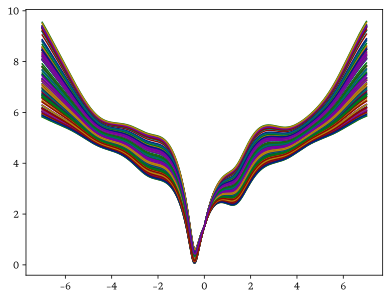

In [34]:
def gen_outcome(params_key, features):
    
    def main_effect(x, p):
      return jnp.log(x**2 + 1.0 + jnp.sin(x*3.0)) + 1.5 + 0.2*jnp.sin(jnp.abs(x))*p + 0.1*jnp.abs(x)*p 
    p = jax.random.uniform(params_key, minval=0.5, maxval=5., shape=(1,))
    return jax.vmap(partial(main_effect, p=p))(features)


key = jax.random.PRNGKey(0)
for _ in range(100):
    key, k1, k2 = jax.random.split(key, 3)
    xs = jnp.linspace(-7., 7., 1000)
    ys = gen_outcome(k2, xs)
    idx = jnp.argsort(xs.reshape(-1,))
    plt.plot(xs[idx], ys[idx])
plt.show()

#### **Sample Data**

In [35]:
scaling_factor = 0.1
def sample(key, n, d):
    k1, k2, k3 = jax.random.split(key, 3)
    cluster_feature = jax.random.uniform(k2)
    params_key = value_to_key(cluster_feature)
    means = jax.random.uniform(k1, shape=(d,), minval=-5., maxval=5.) #jnp.zeros(shape=(d,))#
    cov = jnp.eye(d) * scaling_factor
    xs = jax.random.multivariate_normal(k2, mean=means, cov=cov, shape=(n,))
    features = xs 
    outcomes = gen_outcome(params_key, features) + 0.1*jax.random.normal(key, shape=(n,1))
    return features, outcomes

In [36]:
mlp = MLP([nodes, nodes], jax.nn.relu)
final_activation_fn = lambda x: x; print(f"Final Activation Function: {final_activation_fn}")
model = Model(mlp, final_activation_fn)
supervised_loss = Supervised_Loss(mse, model.fwd_pass) #*** I am not sure this is correct***
standard_yuri = Trainer(supervised_loss, optax.sgd(learning_rate=lr, momentum=0.9), epochs)


inner_yuri = Trainer(supervised_loss, optax.sgd(learning_rate=inner_lr), inner_epochs)
cluster_loss_train = Cluster_Loss(inner_yuri, reg_value)
cluster_loss_val = Cluster_Loss(inner_yuri, 0.0)
cluster_yuri = Trainer(cluster_loss_train,   optax.sgd(learning_rate=lr, momentum=0.9), epochs, val_loss_fn=cluster_loss_val)

Final Activation Function: <function <lambda> at 0x7f7cd473cdc0>


In [37]:
def get_data_params(key, n, c, d):
    k1, k2, k3 = jax.random.split(key, 3)
    batch_inputs, batch_outcomes  = jax.vmap(partial(sample, n=n, d=d))(jax.random.split(k1, c))
    inputs = rearrange(batch_inputs, 'a b c -> (a b) c')
    outcomes = rearrange(batch_outcomes, 'a b c -> (a b) c')

    inputs_standardized = jax.nn.standardize(inputs, axis=0)
    batch_inputs_standarized = rearrange(inputs_standardized, '(a b) c -> a b c', a=c)

    train_group = jax.random.choice(k2, jnp.arange(c), replace=False, shape=(k,))
    training_group = jnp.isin(jnp.arange(c), train_group)
    training_mask = jnp.repeat(training_group, n)
    validation_mask = ~training_mask
    batch_training_mask = rearrange(training_mask, '(a b) -> a b', a=c)
    batch_validation_mask = rearrange(validation_mask, '(a b) -> a b', a=c)

    params = ModelParams.init_fn(k3, mlp, d)

    return {'inputs_standarized': inputs_standardized,
            'batch_inputs_standarized': batch_inputs_standarized,
            'outcomes': outcomes,
            'batch_outcomes': batch_outcomes, 
            'training_group': training_group,
            'training_mask': training_mask, 
            'batch_training_mask': batch_training_mask,
            'validation_mask': validation_mask, 
            'batch_validation_mask': batch_validation_mask,
            'params': params, 
            'batch_inputs':batch_inputs,
            }


In [38]:
def cluster_simulate(key, n, c, d):
    setup = get_data_params(key, n, c, d)
    params, opt_params, training_loss, validation_loss = cluster_yuri.train_with_val(setup['params'],
                                                                                setup['batch_inputs_standarized'],
                                                                                setup['batch_outcomes'],
                                                                                mask=jnp.ones_like(setup['batch_outcomes']), 
                                                                                train_idx=setup['batch_training_mask'], 
                                                                                val_idx=setup['batch_validation_mask'])
    return  setup, opt_params, training_loss, validation_loss

#### **Sub Sample Train**

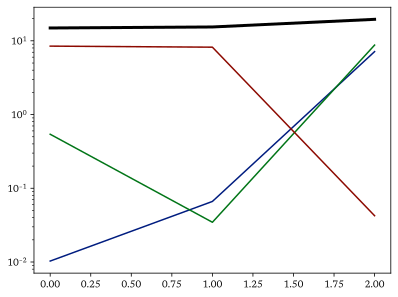

In [39]:
results = []
differences = []
key = jax.random.PRNGKey(0)

    
setup, params, training_loss, validation_loss = cluster_simulate(key, n, c, d)
_, l0 = jax.vmap(partial(inner_yuri.train, params))(setup['batch_inputs_standarized'], setup['batch_outcomes'], jnp.ones_like(setup['batch_outcomes']))

ft_params, ft_lossses = jax.vmap(partial(standard_yuri.train, params), out_axes=(0, 0))(setup['batch_inputs_standarized'], setup['batch_outcomes'], jnp.ones_like(setup['batch_outcomes']))
leaves, treedef = jax.tree.flatten (ft_params)
stacked_ft_params = [treedef.unflatten(x) for x in zip(*leaves)]  


fig, ax = plt.subplots()


for i in stacked_ft_params:
    _, l1 = jax.vmap(partial(inner_yuri.train, i))(setup['batch_inputs_standarized'], setup['batch_outcomes'], jnp.ones_like(setup['batch_outcomes']))
    plt.plot(l1[:,-1])
plt.plot(l0[:,-1], linewidth=3, color='black')

ax.set_yscale('log')
plt.show()


In [43]:
l0

Array([[15.506226, 14.932736],
       [19.130053, 15.411113],
       [25.550106, 19.569818]], dtype=float32)

In [44]:
l1

Array([[ 8.831006  ,  8.472778  ],
       [10.22434   ,  8.198666  ],
       [ 0.04242119,  0.04241541]], dtype=float32)

In [40]:
a, b = inner_yuri.train(params, setup['batch_inputs_standarized'][0],  setup['batch_outcomes'][0],  jnp.ones_like(setup['batch_outcomes'])[0])

In [41]:
b

Array([15.506226, 14.932735], dtype=float32)

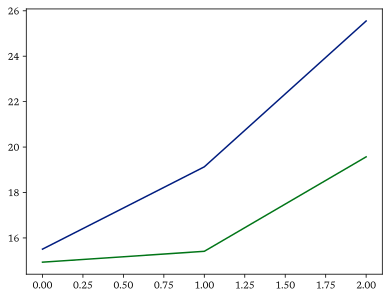

In [42]:
plt.plot(l0)
plt.show()